# Segmentation

Segmentation is, basically, more precise object localization. Instead of finding the bounding box for a particular object of interest, the goal is to identify all the pixels that belong to a particular object. In the following image, the training data labels come in the form of the rightmost image:

![](img/pet_annotations.jpg)

> Image source Oxford Pet dataset: http://www.robots.ox.ac.uk/~vgg/data/pets/

Similar to localization, this can be done for single objects, multiple objects, and with or without classification. In this lab we'll use the same dataset as the previous lab, the Oxford Pets dataset. But this time, instead of using the XML bounding box information as the labels, we're going to use the "trimap" images. 

These images label each pixel in the input image as one of three things:

* The background (more specifically, everything that is NOT part of the object of interest).
* The border of the object of interest.
* The internal portion of the object of interest. 

Unlike multiple object localization, in segmentation it is common to explicitly ignore the idea of "counting" or "enumerating" the individual things in an image. Instead the goal is to correctly label each pixel. One cat, two cats, three cats, it doesn't matter — your goal is to predict which pixels are any part of any cat, and which ones are not. This is called "semantic segmentation". There are applications that perform "instance segmentation" which does attempt to simultaniously identify the segmentation map as well as identify separate instances of objects. 

Localization and segmentation may complement each other in a computer vision pipeline. Consider, for example, the potential value in using a high quality semantic segmentation map as the input to a multi-object localization network.

We're going to heavily leverage the code from the last lab, since we're using the same dataset. We're also going to continue to use MobileNetV2 and transfer learning in order to get better results more quickly. If you skipped ahead, it will be very useful to look at the Object Localization lab before continuing, if only to see how we're processing the Oxford Pets dataset. 

In [1]:
# All the imports:
from collections import namedtuple
import csv

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2DTranspose, add as keras_add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image, ImageOps

In [2]:
# First, we have to download and prepare the data. We're using the Oxford Pet dataset
# linked above. You need the "dataset" and the "groundtruth data" listed under Downloads

# Modify these to fit wherever you save the data.
PATH_TO_IMAGES = 'images/images/images'
PATH_TO_CLASS_LIST = 'annotations/annotations/annotations/list.txt'
PATH_TO_TRIMAPS = 'annotations/annotations/annotations/trimaps'

# Change if you wish. 
TARGET_SIZE = (224, 224)

In [3]:
# This should look familiar by now. We removed the bounding box specific stuff.
# We will be using this process on BOTH the input images and the trimaps.
def resize_image(path_to_image, target_size=None, pad_with_value=0):
    image = Image.open(path_to_image)
    width, height = image.size
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad), pad_with_value)
    
    if target_size is not None:
        # Note, width and height have changed due to the padding resize.
        # Update our notions so we get the scale factor right
        width, height = image.size

        image = image.resize(target_size)
        
        width_scale = target_size[0] / width
        height_scale = target_size[1] / height

    # This is a change, this function now handles data with either 1 or 3 color 
    # channels. We can detect this from the shape of the np.array so we've broken
    # this line into 3. 
    image_as_array = np.array(image.getdata())
    if len(image_as_array.shape) == 2:
        # This is required to handle transparency, which some of the JPGs contain.
        # We are essentially removing the alpha channel. 
        if image_as_array.shape[1] == 4:
            image_as_array = image_as_array[:, 0:3]
        image_data = image_as_array.reshape(image.size[0], image.size[1], 3)
    else:
        image_data = image_as_array.reshape(image.size[0], image.size[1])
    
    # Image data is a 3D array, 3 channels (RGB) of target_size.
    # RBG values are from 0-255. Later in this notebook we preprocess
    # those images with the MobileNetV2 preprocess input function.     
    return image_data

In [4]:
# Given a reshaped trimap, reduce it such that it contains
# 2 values: 0 for "not object of interest" and 1 for "object of interest"

# Note that, this transform includes the "unclassified" border zone
# as part of the background. If you wanted to explicitly classify
# the border seprately from the image you'd have to make this transform
# more involved, and not reduce the trimap to jsut values. 

# Similarly, if you had examples with dogs and cats in the same image
# This reduction step would have to account for those values differently
def reduce_trimap_values(trimap):
    return np.where((trimap == 1), 1, 0)

In [5]:
# Given the relevant data from a row of the CSV return a reshaped image
# as well the reshaped trimap
def prepare_sample_from_name(sample_name):
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    path_to_trimap = os.path.join(PATH_TO_TRIMAPS, sample_name + '.png')

    image_data = resize_image(path_to_image, TARGET_SIZE)
    
    # Note that in OUR TRIMAPS 1 is the value for "background"
    # The final value of 2 is specific to our dataset!!
    trimap = resize_image(path_to_trimap, TARGET_SIZE, 2) 
    
    return (image_data, trimap)

In [6]:
# Plot just the image, or just the trimap, by leaving them none. 
# If both are specified the trimap will be printed on top of the image
# in a semi-transparent way. I love how easy this one is. 
def plot_with_trimap_overlay(image=None, trimap=None):
    if image is not None:
        plt.imshow(image)
    
    if trimap is not None:
        plt.imshow(trimap, alpha=.5)
    
    plt.colorbar()
    plt.show()
    

(224, 224, 3) (224, 224)


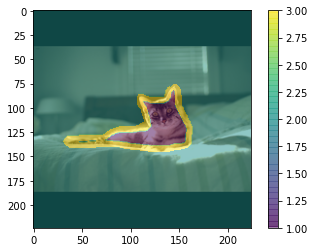

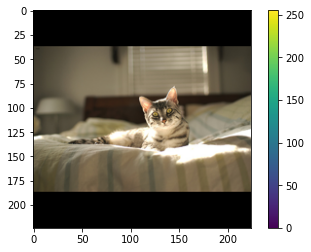

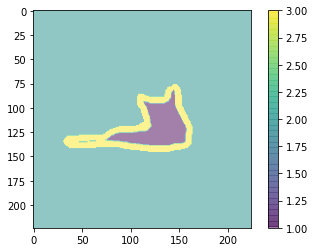

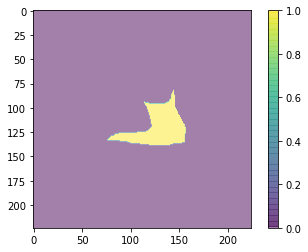

In [7]:
# Lets test out our functions
sample_name = 'Egyptian_Mau_15'
image, trimap = prepare_sample_from_name(sample_name)

print(image.shape, trimap.shape)

plot_with_trimap_overlay(image, trimap)
plot_with_trimap_overlay(image=image)
plot_with_trimap_overlay(trimap=trimap)
plot_with_trimap_overlay(trimap=reduce_trimap_values(trimap))

In [8]:
# Okay, lets get all our samples processed. After this we'll prepare the 
# data and labels for our network and perform a validation split.
processed_data = []

# Processing all this data takes some time... 
# Took my laptop roughly 8 minutes
with open(PATH_TO_CLASS_LIST) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    
    for row in csv_reader:
        if row[0].startswith('#'): continue
        
        # Unpack for readability
        sample_name, class_id, species, breed_id = row

        # Not every image has a bounding box, some files are missing.
        # Use a try/except block to ignore such samples
        try:
            image, trimap = prepare_sample_from_name(sample_name)
        except FileNotFoundError:
            # More images have their trimap than had their bounding box
            # which is a small surprise.
            print(f'No annotations for {sample_name}: skipped.')
            continue
        
        # species - 1 so cat = 0 and dog = 1.
        # Makes things a little easier to process
        data_tuple = (image, int(species) - 1, trimap)
        processed_data.append(data_tuple)
        
print(f'Processed {len(processed_data)} samples')

# Make it a numpy array
processed_data = np.array(processed_data)

Processed 7349 samples


4548 dog


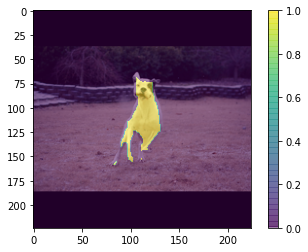

3230 cat


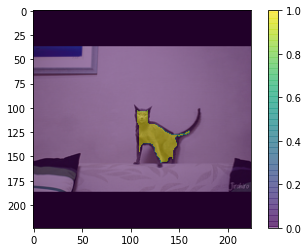

2968 dog


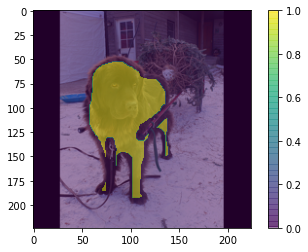

798 dog


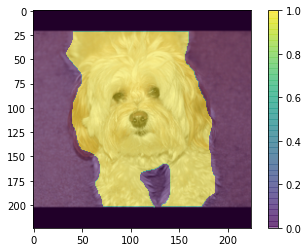

6238 dog


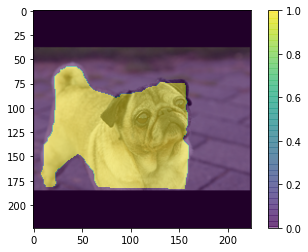

In [9]:
# Lets just do some random spot checking
for _ in range(5):
    i = np.random.randint(len(processed_data))
    image, species, trimap = processed_data[i]
    
    if species == 0:
        print(i, "cat")
    elif species == 1:
        print(i, "dog")
    else:
        print("ERROR DETECTED: Invalid species type")
        
    plot_with_trimap_overlay(image, reduce_trimap_values(trimap))

In [10]:
# This time around, instead of training two outputs on a single network
# we're going to have the final output layer produce 3 activation maps
# One activation map each for the location of cats, dogs, and background

# In our dataset, for the true labels, one of these panes will always
# be empty (all 0), because our dataset never has images with a cat and 
# a dog in the same image. 

# We'll test our network afterwards on a few images with both
# dogs and cats, and see what happens... cross your fingers, but don't hold your breath!
x_train = []
y_train = []

x_validation = []
y_validation = []

validation_split = 0.2

# Notice that we're applying the preprocess_input function to the images here.
# Also note that our labels are shaped (w, h, 3), one pane each for "cat, dog, background"
for image, species, trimap in processed_data:
    processed_image = preprocess_input(image)
    
    # 3 panes each with binary values. Note they mutually exclusive, each pixel can be "on"
    # in exactly ONE of the three following maps.
    cat_segmentation = reduce_trimap_values(trimap) if species == 0 else np.zeros(trimap.shape)
    dog_segmentation = reduce_trimap_values(trimap) if species == 1 else np.zeros(trimap.shape)
    bg_segmentation = np.logical_not(reduce_trimap_values(trimap))
    
    if np.random.random() > validation_split:
        x_train.append(processed_image)
        y_train.append([cat_segmentation, dog_segmentation, bg_segmentation])
    else:
        x_validation.append(processed_image)
        y_validation.append([cat_segmentation, dog_segmentation, bg_segmentation])
        
x_train = np.array(x_train)
y_train = np.array(y_train)

x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

# Because of how we appeneded the cat and dog data to the labels
# we need to change the dimensions before prediction so that the
# color channels are where the network expects them:
y_train = np.rollaxis(y_train, 1, 4)
y_validation = np.rollaxis(y_validation, 1, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3) (224, 224, 3)


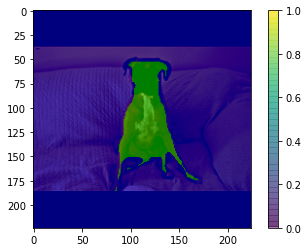

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3) (224, 224, 3)


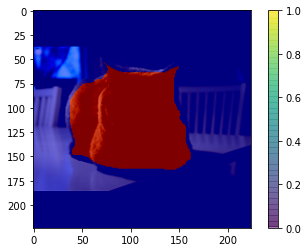

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3) (224, 224, 3)


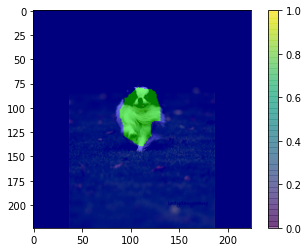

(224, 224, 3) (224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


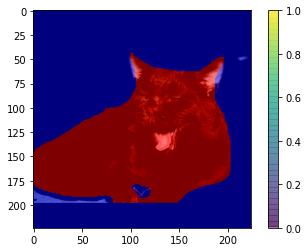

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3) (224, 224, 3)


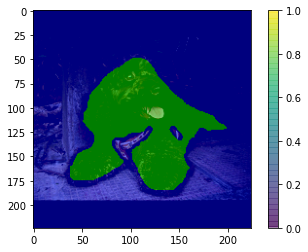

In [11]:
# Lets just do some random spot checking
for _ in range(5):
    i = np.random.randint(len(x_train))
    image = x_train[i]
    label = y_train[i]    
    
    # Note that it is coincidence that these are the same shape!!!
    # The image is 3 color channels, the label is 3 classes (cat, dog, background)
    # The result is R = cat, G = dog, B = background when using imshow
    print(image.shape, label.shape)
    plot_with_trimap_overlay(image, label)

In [12]:
# We don't have a TON of data, but we could actually do some data augmentation
# Because the label data is in the same format as the input. We'd have to 
# transform the labels which is not built into Keras, but might be a good exercise
# for later... 

# Lets still use transfer learning
# Like before, we grab a pretrained model with include_top=False
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we have to use "Convolution Transpose" sometimes called "Deconvolution" to 
# re-increase the resolution, since MobileNetV2 significantly reduces the input size
# Drawing on inspiration from U-Net, we're also going to add some symmetric skip connections
# which should make us feel *very* fancy. 
segmentation_output = Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(chopped_mobilenet.output)

segmentation_output = Conv2DTranspose(24, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(
    keras_add([segmentation_output, base_model.layers[45].output])
)

segmentation_output = Conv2DTranspose(24, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(
    keras_add([segmentation_output, base_model.layers[27].output])
)

# Note: we use 3 frames, one for cat one for dog one for background, and we 
# and likely improve our result, especially with respect to generalization and finding
# BOTH cats and dogs in the same image. Plus, it would allow us to detect the absense
# of either cats or dogs more readily. 
segmentation_output = Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='softmax')(segmentation_output)

model = Model(inputs=[chopped_mobilenet.input], outputs=[segmentation_output])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [13]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

# Warning, this takes forever. 
model.fit(x_train, y_train, 
          validation_data=(x_validation, y_validation),
          epochs=10,
          verbose=True
)

Epoch 1/10
  2/185 [..............................] - ETA: 16:53 - loss: 1.7161 - accuracy: 0.3389

KeyboardInterrupt: 

In [ ]:
import os
model.save(os.path.join("saved_models", "segmentation_example.h5"))

In [ ]:
for _ in range(10):
    i = np.random.randint(len(y_validation))
    img = x_validation[i]
    label = y_validation[i]
    pred = model.predict(np.array([img]))
    
    pred_panes = pred[0]
    pred_panes_maxed = np.argmax(pred_panes, axis=2)
    

    print("True Label")
    plot_with_trimap_overlay(img, label)
    
    print("Prediction")
    plot_with_trimap_overlay(img, pred_panes_maxed)

In [ ]:
# Lets see how it does on some random images from the internet...
# These are actually included in the repo.
photo_dir = 'img'
photos = [
    'cat1.png',
    'cat2.png',
    'dog1.png',
    'dog2.png',
    'dog-cat1.png'
]

for photo in photos:
    photo_path = os.path.join(photo_dir, photo)
    resized_photo = resize_image(photo_path, TARGET_SIZE)
    processed_photo = preprocess_input(resized_photo)
    pred = model.predict(np.array([processed_photo]))
    
    pred_panes = pred[0]
    pred_panes_maxed = np.argmax(pred_panes, axis=2)
    plot_with_trimap_overlay(resized_photo, pred_panes_maxed)

In [ ]:
# Pretty decent for so few training rounds.. but clearly not ready for production either.
# There are other architectures (e.g. Unet) that can achieve much better results on segmentation.
# And, as always, more data, more training, and more data augmentiation can all help. 